In [1]:
import datetime

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import tushare as ts

In [7]:
import seaborn as sns;

In [34]:
from scipy import stats

In [10]:
import pandas.io.data as web

### 下载上证综指过去1年的收盘数据，以此来计算日收益率序列，对这个数据画出直方图，计算这组数据的各个描述性统计量

In [11]:
end = datetime.datetime.today()
start = end - datetime.timedelta(days = 365)

In [12]:
data = web.DataReader("000001.SS",'yahoo',start,end)

In [27]:
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-03-18,3577.30,3577.30,3577.30,3577.30,0,3577.30
2015-03-19,3582.27,3582.27,3582.27,3582.27,0,3582.27
2015-03-20,3617.32,3617.32,3617.32,3617.32,0,3617.32
2015-03-23,3687.73,3687.73,3687.73,3687.73,0,3687.73
2015-03-24,3691.41,3691.41,3691.41,3691.41,0,3691.41


In [30]:
data2= ts.get_hist_data('000001',start='2015-03-24',end='2016-03-15')

In [31]:
data2.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
date,,,,,,,,,,,,,,
2016-03-15,10.28,10.36,10.32,10.16,417920.38,0.06,0.58,10.212,10.229,10.093,451347.26,611719.80,536509.67,0.35
2016-03-14,10.21,10.46,10.26,10.21,655158.25,0.10,0.98,10.204,10.167,10.077,496394.48,607718.84,537032.97,0.56
2016-03-11,10.10,10.22,10.16,10.04,383736.72,0.01,0.10,10.220,10.097,10.054,486633.43,598892.66,518200.03,0.33
2016-03-10,10.24,10.35,10.15,10.13,474020.31,-0.02,-0.20,10.268,10.060,10.042,686135.91,599734.43,512557.86,0.40
2016-03-09,10.14,10.22,10.17,10.04,325900.66,-0.11,-1.07,10.260,10.012,10.032,701949.72,614539.68,507511.82,0.28


In [15]:
close_price = data['Adj Close']

In [18]:
d_return=(close_price/close_price.shift(1)-1).dropna()

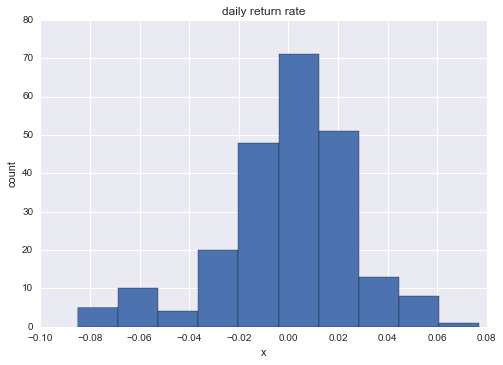

In [19]:
fig, ax = plt.subplots()

d_return.hist(ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('count')
ax.set_title('daily return rate')

接下来看它们的描述统计量

In [20]:
d_return.mean()

-0.0005916793798600204

In [23]:
d_return.argmax(),d_return.max()

(Timestamp('2015-10-12 00:00:00'), 0.076939707414225511)

In [24]:
d_return.describe()

count    231.000000
mean      -0.000592
std        0.026741
min       -0.084907
25%       -0.012569
50%        0.001989
75%        0.017221
max        0.076940
Name: Adj Close, dtype: float64

In [35]:
stats.describe(d_return)

DescribeResult(nobs=231, minmax=(-0.084906521007828362, 0.076939707414225511), mean=-0.0005916793798600204, variance=0.00071506821978878224, skewness=-0.6639170356550235, kurtosis=1.1234576098276614)

##  概率密度函数估计

假设是正态分布，估计出来的参数和概率密度函数如下：

In [38]:
loc,scale = stats.norm.fit(d_return)
(loc,scale)

(-0.0005916793798600204, 0.026682816312559345)

In [39]:
pdf = stats.norm(loc=loc, scale=scale).pdf

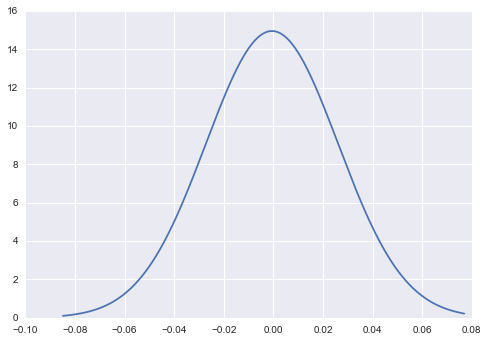

In [42]:
fig,ax = plt.subplots()
x = np.linspace(d_return.min(),d_return.max(),1000)
ax.plot(x,pdf(x));

In [43]:
p = stats.norm(loc, scale=scale).cdf(0)
p

0.50884563965628971

## 非参数方法

In [44]:
kde = stats.kde.gaussian_kde(d_return)

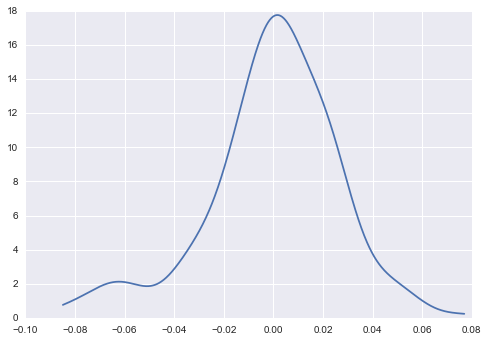

In [45]:
fig, ax = plt.subplots()
x = np.linspace(d_return.min(), d_return.max(), 1000)
ax.plot(x, kde.pdf(x));

In [46]:
p = kde.integrate_box_1d(-np.inf, 0)
p

0.47032621022160492

## 比较2支股票数据是否有差异（统计检验）

In [47]:
def daily_return(stock, start=(datetime.datetime.today() - datetime.timedelta(days=365)), end=datetime.datetime.today()):
    data = web.DataReader(stock, 'yahoo', start, end)['Close']
    daily_return = (data.diff() / data.shift(periods=1)).dropna()
    return daily_return.values

In [55]:
apple = daily_return('AAPL')
goog = daily_return('GOOG')

In [58]:
stats.normaltest(apple),stats.normaltest(goog)  #判断是否正态分布

(NormaltestResult(statistic=12.966790495807869, pvalue=0.0015286118424946012),
 NormaltestResult(statistic=185.63585100804312, pvalue=4.8942610710986921e-41))

QQPLOT图来直观检视

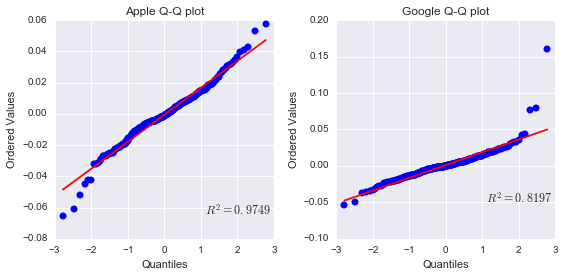

In [59]:
fig, axes = plt.subplots(1,2,figsize=(8, 4))
stats.probplot(apple, plot=axes[0])
stats.probplot(goog, plot=axes[1])
axes[0].set_title('Apple Q-Q plot')
axes[1].set_title('Google Q-Q plot')
fig.tight_layout()

利用 Q-Q plot，发现两者正态分布拟合不是那么好，存在偏离值.因此使用mann-whitney-u test 更好

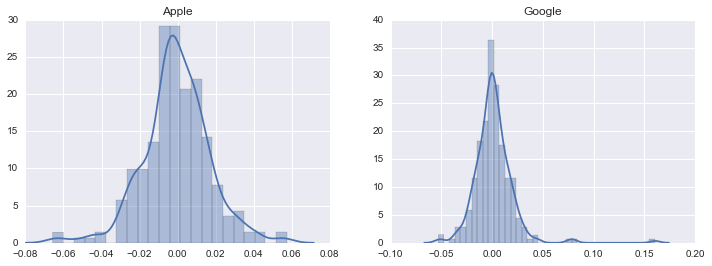

In [56]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

sns.distplot(apple,ax=ax[0])
ax[0].set_title('Apple')

sns.distplot(goog,ax=ax[1])
ax[1].set_title('Google');

In [54]:
u, p = stats.mannwhitneyu(apple, goog) #采用mann-whitney u test
u, p

(27129.0, 0.0035745992665985314)

p值大于0.05，apple公司和google公司收益率无显著差异